# LangGraph Agent - Python Cookbook

### llm setup for LangChain

In [1]:
from dotenv import load_dotenv
from langchain_google_genai import ChatGoogleGenerativeAI
load_dotenv()

llm = ChatGoogleGenerativeAI(model='gemini-2.5-flash',temperature=0)


### tools

In [2]:
from langchain_core.tools import tool
from langchain_tavily import TavilySearch

@tool
def get_weather(city: str, unit: str = 'celsius') -> str:
	"""Get the weather for a city."""
	return f"The weather in {city} is 25 degrees {unit}."

@tool
def web_search(query: str) -> str:
	"""Search the web for a query."""
	tavily_search_tool = TavilySearch(
		max_results=5,
		topic="general",
	)
	return tavily_search_tool.invoke(query)

TOOL_MAP = {
	"get_weather": get_weather,
	"web_search": web_search,
}

### Add tools to the llm

In [3]:
llm = llm.bind_tools([get_weather, web_search])

### State - Message from Langchain

### Reducers

##### What? - Reducers are functions to apply updates from nodes to state

In [4]:
from typing import Annotated, TypedDict
from langchain_core.messages import AnyMessage, HumanMessage, AIMessage

from langgraph.graph.message import add_messages # add_messages is the reducer to add messages to the state

class MessagesState(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]

In [5]:
# BTS of add_messages - reference: https://github.com/langchain-ai/langchain-academy/blob/main/module-1/chain.ipynb 

initial_messages = [AIMessage(content="Hello! How can I assist you?", name="Model"),
                    HumanMessage(content="I'm looking for information on marine biology.", name="Lance")
                   ]

# New message to add
new_message = AIMessage(content="Sure, I can help with that. What specifically are you interested in?", name="Model")

# Test
add_messages(initial_messages , new_message)

[AIMessage(content='Hello! How can I assist you?', additional_kwargs={}, response_metadata={}, name='Model', id='8d404f27-6ea1-4779-ab07-c9cd7914931f'),
 HumanMessage(content="I'm looking for information on marine biology.", additional_kwargs={}, response_metadata={}, name='Lance', id='4124ace2-92d1-408b-9fed-80e30e0aaa24'),
 AIMessage(content='Sure, I can help with that. What specifically are you interested in?', additional_kwargs={}, response_metadata={}, name='Model', id='e6e96af2-08cf-4ccb-bb1a-9f99af07489a')]

### Node

In [13]:
from langchain_core.messages import SystemMessage

sys_msg = SystemMessage(
		content="You are a helpful tour planning assistant that can help users for making itinerary. You can plan the trip from checking the weather, searching for rooms and searching interesitng things and places to go out for.",
	)

def react_agent(state: MessagesState):
	llm_output = llm.invoke([sys_msg] + state["messages"])
	return {"messages": [llm_output]}

### Build Graph

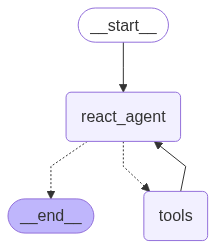

In [14]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition


builder = StateGraph(MessagesState)
builder.add_node("react_agent", react_agent)
builder.add_node("tools", ToolNode([get_weather, web_search]))
builder.add_edge(START, "react_agent")
builder.add_conditional_edges(
	"react_agent",
	tools_condition
)
builder.add_edge("tools", "react_agent")
graph = builder.compile()


display(Image(graph.get_graph().draw_mermaid_png()))

### Invoke Graph

#### a. simple message - requring no tools

In [11]:
messages = graph.invoke({"messages": [HumanMessage(content="What up!")]})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

What up!
================================== Ai Message ==================================

Hello! I'm here to help you plan your next adventure. What can I do for you?


#### b. tool calling - invoking all tools

In [17]:
messages = graph.invoke({"messages": [HumanMessage(content="Plan a trip to San Francisco, for next weekend")]})
for m in messages['messages']:
	m.pretty_print()

================================ Human Message =================================

Plan a trip to San Francisco, for next weekend
================================== Ai Message ==================================
Tool Calls:
  get_weather (3b0f9fbb-c246-4f95-8353-0f20132f56b9)
 Call ID: 3b0f9fbb-c246-4f95-8353-0f20132f56b9
  Args:
    city: San Francisco
================================= Tool Message =================================
Name: get_weather

The weather in San Francisco is 25 degrees celsius.
================================== Ai Message ==================================
Tool Calls:
  web_search (8b7e78f9-c6d1-4115-9f36-37528189c60f)
 Call ID: 8b7e78f9-c6d1-4115-9f36-37528189c60f
  Args:
    query: Things to do in San Francisco next weekend
================================= Tool Message =================================
Name: web_search

{"query": "Things to do in San Francisco next weekend", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https

#### c. tool calling - with web_search tool

In [16]:
messages = graph.invoke({"messages": [HumanMessage(content="What is the current news in NY?")]})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

What is the current news in NY?
================================== Ai Message ==================================
Tool Calls:
  web_search (fac76acf-5884-4a00-9f59-91c07bea5faf)
 Call ID: fac76acf-5884-4a00-9f59-91c07bea5faf
  Args:
    query: current news in NY
================================= Tool Message =================================
Name: web_search

{"query": "current news in NY", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://www.cbsnews.com/newyork/local-news/new-york/", "title": "New York News", "content": "Amber Alert issued for missing child in Lake George, N.Y. · 2H ago ; High humidity and chance of severe storms around NYC area today · 3H ago ; Off-duty law", "score": 0.54594, "raw_content": null}, {"url": "https://www.nbcnewyork.com/", "title": "NBC 4 New York – NY local news, breaking news, weather", "content": "Manhattan · Off-duty border patrol 